work on:

X cooling schedule (exponential decay)

ode

X accept 98% (only for present settings)

determine right samplingspace

X randomly change one or more variables


Can we not get stuck in a local minimum by changing one parameter at a time? see picture '2dLocalMinima'

Annealing temperature:

A good rule of thumb is that your initial temperature Tmax should be set to accept roughly 98% of the moves 
and that the final temperature Tmin should be low enough that the solution does not improve much, if at all.

The number of steps can influence the results; 
if there are not enough iterations to adequately explore the search space it can get trapped at a local minimum.

steven said a samplingspace of 2 should work

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// from https://stackoverflow.com/questions/36757301/disable-ipython-notebook-autoscrolling
// disable scroll

<IPython.core.display.Javascript object>

In [3]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error as detMSE
from scipy.integrate import odeint
#from scipy.spatial import distance

In [17]:
# set temperatures
def temperature(TMax,time):
    T = TMax * np.e**(-1./(TMax / 10.)*time)
    return T

# differential equation for prey
def dx(alfa, x, beta, y):
    dx = alfa * x - beta * x * y
    return dx

# differential equation for predators
def dy(delta, x, y, gamma):
    dy = delta * x * y - gamma * y
    return dy

# solving differential equations using Euler method
def EulerSolveODE(x,y,parameters, times):
    for month in times:
        xList.append(x)
        yList.append(y)    
        x += dx(parameters[0], x, parameters[1], y)
        y += dy(parameters[2], x, y, parameters[3]) 

# solving differential equations using scipy ode int         
def pend(f, t, a, b, c, d):
    x, y = f
    dfdt = [a*x - b*x*y, d*x*y - c*y]
    return dfdt        
        
# randomly change one of the parameters 
# all change at equal probability
# the parameter is changed to a completely new number in the range
def changeParameter(parameters, samplingSpace):
    randomNumber = np.random.random()
    if randomNumber < 1./4:
        parameters[0] = np.random.random()*samplingSpace
    elif randomNumber < 2./4:
        parameters[1] = np.random.random()*samplingSpace
    elif randomNumber < 3./4:
        parameters[2] = np.random.random()*samplingSpace
    else:
        parameters[3] = np.random.random()*samplingSpace
    return parameters

# randomly change parameters, 
# with p = 1./2 for each parameter to be changed 
# the parameter is changed to a completely new number in the range
def changeMultipleParameters(parameters, samplingSpace):
    change = 0
    while change == 0:
        randomNumber = np.random.random()
        if randomNumber < 1./2:
            parameters[0] = np.random.random()*samplingSpace
            change = 1
        randomNumber = np.random.random()
        if randomNumber < 1./2:
            parameters[1] = np.random.random()*samplingSpace
            change = 1
        randomNumber = np.random.random()
        if randomNumber < 1./2:
            parameters[2] = np.random.random()*samplingSpace
            change = 1
        randomNumber = np.random.random()
        if randomNumber < 1./2:
            parameters[3] = np.random.random()*samplingSpace
            change = 1
    return parameters

In [18]:
# import csv using pandas
# create 3 data lists: time, prey and predators
pandaFile = pandas.read_csv('predator-prey-data.csv')
times = []
xValues = []
yValues = []
for row in range(len(pandaFile['t'])):
    time = pandaFile['t'][row]
    x = pandaFile['x'][row]
    y = pandaFile['y'][row]
    times.append(time)
    xValues.append(x)
    yValues.append(y)

In [19]:
# using scipy odeint
# prey and predators are float numbers

# initial guesses

# set the initial amount of prey and predators equal to those of the real data
x = xValues[0] #amount of prey
y = yValues[0] #amount of predators

# set the sampling space
samplingSpace = 10

# assign a random number to the parameters in the range
alfa = np.random.random()*samplingSpace #birth rate prey
beta = np.random.random()*samplingSpace #prey catch rate
delta = np.random.random()*samplingSpace #birth of predators per predator per prey
gamma = np.random.random()*samplingSpace #death rate predators
establishedParameters = [alfa,beta,delta,gamma]

# assign the cooling schedule
TMax = 20000 # proper starting temperature for samplingspace = 0.1
temperatures = []
for time in range(20000):
    T = temperature(TMax,time)
    temperatures.append(T)

#TMin = 19000#1
#temperatures = np.arange(TMax,TMin-1,-1)

# assign a high number to the mean squared error 
#hoping the first random guess of the parameters will lead to acceptance
mse = 999999999

# track how often new values are assigned
trackAcceptance = [0,0]
#MSEDifferencePerT = []

# simulating annealing
for T in temperatures:
    
    # set newParameters almost equal to establisedParameters
    # changing only 1 using the function changeParameter
    newParameters = changeMultipleParameters(establishedParameters, samplingSpace)
    
    # using scipy odeint
    # calculate the amount of prey and predators for each time point indicated from data
    # assume all time point lie at equal distance
    #xList = [] obsolete for odeint?
    #yList = [] obsolete for odeint?
    
    y0 = [3, 3]
    
    sol = odeint(pend, y0, times, args=tuple(newParameters))
    
    #determine mse of prey and predators
    msePrey = detMSE(xValues, [el[0] for el in sol])
    msePredators = detMSE(yValues, [el[0] for el in sol])
    mseSum = msePrey + msePredators
    
    """
    # calculate the amount of prey and predators for each time point indicated from data
    # assume all time point lie at equal distance
    xList = []
    yList = []
    EulerSolveODE(x,y,newParameters, times)
    
    #determine mse of prey and predators
    msePrey = detMSE(xValues,xList)
    msePredators = detMSE(yValues,yList)
    mseSum = msePrey + msePredators
    """
    # if the new mean squared error is smaller than the old, 
    # accept newParameters as establisedParameters
    # take the lower mean squared error as the new benchmark
    if mseSum < mse:
        establishedParameters = newParameters
        mse = mseSum
        
        trackAcceptance[0] += 1
        
        
    # if the new mean squared error is almost as small as the old,
    # accept newParameters as establisedParameters 
    # take the lower mean squared error as the new benchmark
    elif (mseSum - mse)/T < np.random.random():
        establishedParameters = newParameters
        mse = mseSum 
        
        trackAcceptance[1] += 1
        # track the score difference
        #MSEDifferencePerT.append(mseSum - mse)
        
        
print establishedParameters

/Users/koengreuell/anaconda2/lib/python2.7/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1.985306367147598, 5.347474605574839, 4.875532037273609, 4.441460562113719]


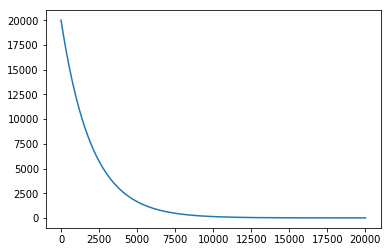

In [20]:
# show the temperature shows exponential decay
plt.plot(range(20000),temperatures)
plt.show()

In [21]:
print sum(trackAcceptance)
print len(temperatures)
print float(sum(trackAcceptance)) / len(temperatures)

14716
20000
0.7358


In [22]:
# run the model with the establised parameters
a, b, c, d = establishedParameters
print a
sol = odeint(pend, y0, times, args=tuple(newParameters))
xList = []
yList = []
for timePoint in sol:
    xList.append(timePoint[0])
    yList.append(timePoint[1])

1.98530636715


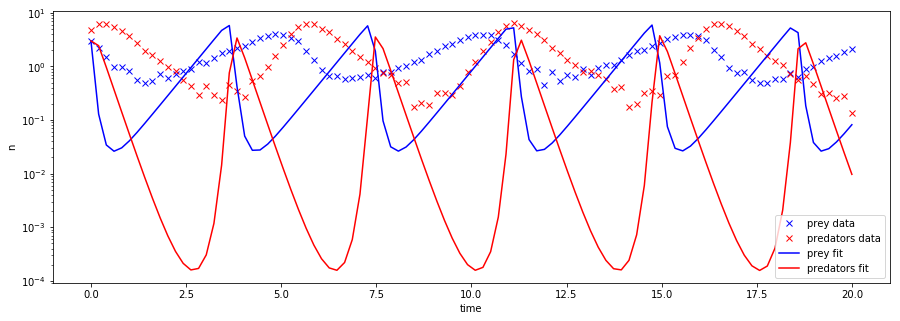

In [23]:
# plot the data and the best fit
plt.figure(figsize=(15,5))
plt.plot(times,xValues,'x', label = 'prey data', color = 'b')
plt.plot(times,yValues,'x', label = 'predators data', color = 'r')
plt.plot(times,xList,label = 'prey fit', color = 'b')
plt.plot(times,yList, label = 'predators fit', color = 'r')
plt.yscale("log")
plt.xlabel('time')
plt.ylabel('n')
plt.legend()
plt.show()